In [ ]:
import numpy as np
import math
import random
from typing import List, Dict, Any, Tuple
import sys
import os
from sklearn.neighbors import NearestNeighbors


# make sure Python can see the compiled Cython module
sys.path.append(r"C:\MDU\Masters\Nature Inspired\Group Project\Group 5\TSP_CYTHON")

from two_opt_cand import two_opt_cand as two_opt_cy
from three_opt_cand import three_opt_cy

# ============================
# GLOBAL CONFIG
# ============================

INSTANCE_PATH = r"gecco19-thief\src\main\resources\a280-n279.txt"

# TSP / 2-OPT
CAND_K = 60
TWO_OPT_PASSES = 2000 # polish

SPARSE_ELITES = 2
TAIL_ELITES = 1
MID_ELITES = 0

# LKH-style TSP (multi-start + 3-opt + ILS)
NUM_STARTS_LKH = 1             # multi-start basins
ILS_RESTARTS_LKH = 500          # double-bridge kicks per best basin
TWO_OPT_MAX_ITERS = 20000      # inner 2-opt budget per LS
THREE_OPT_TRIES_PER_LS = 20000  # random 3-opt attempts per LS
DB_CUTS = 4

VERBOSE = True

ELITE_2OPT_STEPS = 100
ELITE_3OPT_STEPS = 100
ELITE_ILS_PASSES = 5
ELITE_DB_CUTS = 3

HC_STEPS = 4000  # tune later

# EVOLUTION
POP_SIZE = 100
GENERATIONS = 100
TOURN_K = 3

NUM_GREEDIES = 5     # tune to 2-8 depending runtime

# ITEM SEEDING PARAMETERS
CAP_FACTORS = [0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0]
GAMMAS = [0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 6, 8, 10, 15, 20, 30]
HEUR_MODES = ["suffix", "profit_adj", "time_ratio"]
MUT_RATE = 0.003
LIGHT_MUT_RATE = 0.02

GLOBAL_SEED = 0
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# HYPERVOLUME (same reference used in your comparisons)
IDEAL = (2613.0, -42036.0)
NADIR = (5444.0, 0.0)

MAX_ARCHIVE = 100          # same behaviour as second file (cap via crowding)
archive_pop = []          # stores solutions
archive_objs = []         # stores (T,P,W)
# Cache: tour tuple -> (dists_array, tsp_int_length)
TOUR_DIST_CACHE = {}

# Cache: (tour_key, chosen_tuple) -> (T, P, W)
EVAL_CACHE = {}



# Global elites across all generations
bestP = -1.0
bestP_sol = None

bestT = None
bestT_sol = None


# ===============================================================
# PARSE INSTANCE
# ===============================================================
def parse_ttp(path: str) -> Dict[str, Any]:
    with open(path, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    dim = num_items = None
    capacity = v_min = v_max = None
    edge_type = None

    i = 0
    while i < len(lines):
        L = lines[i]
        if L.startswith("DIMENSION"):
            dim = int(L.split(":")[1])
        elif L.startswith("NUMBER OF ITEMS"):
            num_items = int(L.split(":")[1])
        elif L.startswith("CAPACITY OF KNAPSACK"):
            capacity = float(L.split(":")[1])
        elif L.startswith("MIN SPEED"):
            v_min = float(L.split(":")[1])
        elif L.startswith("MAX SPEED"):
            v_max = float(L.split(":")[1])
        elif L.startswith("EDGE_WEIGHT_TYPE"):
            edge_type = L.split(":")[1].strip()
        elif L.startswith("NODE_COORD_SECTION"):
            break
        i += 1

    i += 1
    coords = np.zeros((dim, 2), float)
    for k in range(dim):
        idx, x, y = lines[i + k].split()
        coords[int(idx) - 1] = [float(x), float(y)]
    i += dim

    while "ITEMS SECTION" not in lines[i]:
        i += 1
    i += 1

    items = []
    for j in range(num_items):
        parts = lines[i + j].split()
        profit = float(parts[1])
        weight = float(parts[2])
        city = int(parts[3]) - 1
        items.append((profit, weight, city))

    return {
        "dim": dim,
        "coords": coords,
        "items": items,
        "capacity": capacity,
        "v_min": v_min,
        "v_max": v_max,
        "edge_type": edge_type,
    }


# ===============================================================
# TSP HELPERS (distance matrix, 3-opt, ILS)
# ===============================================================

def compute_dists(order: np.ndarray, coords: np.ndarray) -> np.ndarray:
    n = len(order)
    out = np.empty(n, float)
    for i in range(n):
        a = order[i]
        b = order[(i + 1) % n]
        d = math.sqrt(((coords[a] - coords[b]) ** 2).sum())
        out[i] = math.ceil(d)
    return out


def city_dist(a: int, b: int, coords: np.ndarray) -> float:
    dx = coords[a, 0] - coords[b, 0]
    dy = coords[a, 1] - coords[b, 1]
    return math.ceil(math.hypot(dx, dy))


def build_distance_matrix(coords: np.ndarray, edge_type: str):
    """
    TSPLIB-style distances.

    - EUC_2D:  int( sqrt(dx^2 + dy^2) + 0.5 )
    - CEIL_2D: int( ceil( sqrt(dx^2 + dy^2) ) )
    - else:    raw Euclidean as float
    """
    n = len(coords)
    edge = (edge_type or "").upper()

    dist = [[0.0] * n for _ in range(n)]
    for i in range(n):
        xi, yi = coords[i]
        for j in range(i + 1, n):
            xj, yj = coords[j]
            dx = xi - xj
            dy = yi - yj
            dij = math.sqrt(dx * dx + dy * dy)

            if edge.startswith("EUC_2D"):
                dij = int(dij + 0.5)
            elif edge.startswith("CEIL_2D"):
                dij = int(math.ceil(dij))

            dist[i][j] = dist[j][i] = dij

    return dist

def build_candidate_lists_knn(coords: np.ndarray, k: int):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='kd_tree').fit(coords)
    dists, idxs = nbrs.kneighbors(coords)

    # remove self reference in column 0
    return [list(row[1:]) for row in idxs]

@staticmethod
def dist_xy(a:int, b:int, coords:np.ndarray) -> int:
    dx = coords[a,0] - coords[b,0]
    dy = coords[a,1] - coords[b,1]
    return int((dx*dx + dy*dy)**0.5)



def build_candidate_lists_from_dist(dist, k: int):
    n = len(dist)
    k = min(k, n - 1)
    C = []
    for i in range(n):
        nbr = sorted([(dist[i][j], j) for j in range(n) if j != i])[:k]
        C.append([j for _, j in nbr])
    return C


def tour_length_list(tour, coords, accurate: bool = False) -> float:
    """
    accurate=False → fast integer metric (used inside LKH search)
    accurate=True  → real Euclidean distance for reporting only
    """
    total = 0.0
    for i in range(len(tour)):
        a = tour[i]
        b = tour[(i + 1) % len(tour)]
        dx = coords[a][0] - coords[b][0]
        dy = coords[a][1] - coords[b][1]

        dist = math.hypot(dx, dy)

        if accurate:
            total += dist              # TRUE LENGTH
        else:
            total += int(dist)         # FAST LKH METRIC

    return total

def get_tour_dists(tour, coords):
    """
    Returns (dists_array, tsp_length) for the given tour.
    Cached so we do NOT recompute sqrt/hypot each time.
    """
    key = tuple(tour)
    if key in TOUR_DIST_CACHE:
        return TOUR_DIST_CACHE[key]

    # compute once
    d = compute_dists(tour, coords)
    tsp_len = float(d.sum())

    TOUR_DIST_CACHE[key] = (d, tsp_len)
    return d, tsp_len


def nn_tour(coords: np.ndarray) -> np.ndarray:
    n = len(coords)
    unvis = np.ones(n, dtype=bool)
    tour = np.empty(n, int)
    cur = 0

    for t in range(n):
        tour[t] = cur
        unvis[cur] = False
        if t == n - 1:
            break
        dx = coords[unvis, 0] - coords[cur, 0]
        dy = coords[unvis, 1] - coords[cur, 1]
        nxt = np.where(unvis)[0][np.argmin(dx * dx + dy * dy)]
        cur = nxt

    return tour

def ensure_valid_tour(tour: List[int], n: int) -> List[int]:
    """Repair tour to a valid permutation, starting at 0."""
    seen = set()
    cleaned = []
    for c in tour:
        if 0 <= c < n and c not in seen:
            cleaned.append(c)
            seen.add(c)
    for c in range(n):
        if c not in seen:
            cleaned.append(c)
            seen.add(c)
    if 0 in cleaned:
        k = cleaned.index(0)
        cleaned = cleaned[k:] + cleaned[:k]
    else:
        cleaned = [0] + [c for c in range(1, n)]
    return cleaned[:n]


def nn_tour_from_dist(dist, start: int = 0) -> List[int]:
    n = len(dist)
    unv = set(range(n))
    unv.remove(start)
    t = [start]
    cur = start
    while unv:
        nxt = min(unv, key=lambda j: dist[cur][j])
        t.append(nxt)
        unv.remove(nxt)
        cur = nxt
    return t



def build_sparse_dist_matrix(coords: np.ndarray, cand_lists):
    """
    Sparse candidate graph (KNN edges only) but with safe fallback distances.

    IMPORTANT:
    - All i!=j pairs get a large placeholder distance rather than None.
    - C++ 2-opt/3-opt can now run without crashing when exploring non-K edges.
    - Full NxN storage is still avoided, RAM ~ (n*n*4bytes) only for candidate edges.
    - Distances outside candidate-set behave like LKH prune: "far = unattractive".
    """

    n = len(coords)

    # Large value ensures non-candidate edges remain valid, but undesirable.
    BIG = 10**9

    # Allocate NxN table initialised to BIG instead of None
    dist = [[BIG] * n for _ in range(n)]

    # Fill only KNN-edges with real values
    for i in range(n):
        xi, yi = coords[i]
        for j in cand_lists[i]:
            dx = xi - coords[j, 0]
            dy = yi - coords[j, 1]
            d = int(math.hypot(dx, dy))
            dist[i][j] = d
            dist[j][i] = d   # symmetry preserved

    # Zero diagonal keeps 2-opt stable
    for i in range(n):
        dist[i][i] = 0

    return dist

def eval_cached(inst, tour, dists, recs, chosen):
    key = (tuple(tour), tuple(chosen))
    if key in EVAL_CACHE:
        return EVAL_CACHE[key]
    T, P, W = evaluate(inst, tour, dists, recs, chosen)
    EVAL_CACHE[key] = (T, P, W)
    return T, P, W


def random_greedy_tour_from_dist(dist, cand, alpha: float = 0.3) -> List[int]:
    """
    Randomised greedy: at each step choose among a few nearest neighbours.
    """
    n = len(dist)
    start = 0
    unv = set(range(n))
    unv.remove(start)
    t = [start]
    cur = start

    while unv:
        neigh = [j for j in cand[cur] if j in unv]
        if not neigh:
            neigh = list(unv)
        neigh = sorted(neigh, key=lambda j: dist[cur][j])
        rcl_size = max(1, int(len(neigh) * alpha))
        rcl = neigh[:rcl_size]
        nxt = random.choice(rcl)
        t.append(nxt)
        unv.remove(nxt)
        cur = nxt

    return t


def try_three_opt_move_list(
    tour: List[int],
    dist,
    i: int,
    j: int,
    k: int,
) -> Tuple[bool, List[int], float]:
    """
    Try a subset of 3-opt reconnections on segments:
    [0..i], [i+1..j], [j+1..k], [k+1..end]
    """
    n = len(tour)
    a, b = tour[i], tour[(i + 1) % n]
    c, d = tour[j], tour[(j + 1) % n]
    e, f = tour[k], tour[(k + 1) % n]

    base = dist[a][b] + dist[c][d] + dist[e][f]

    s1 = tour[: i + 1]
    s2 = tour[i + 1 : j + 1]
    s3 = tour[j + 1 : k + 1]
    s4 = tour[k + 1 :]

    best_delta = 0.0
    best_tour = None

    # 1) reverse s2
    cand1 = s1 + list(reversed(s2)) + s3 + s4
    d1 = dist[a][tour[j]] + dist[tour[i + 1]][d] + dist[e][f]
    delta1 = d1 - base
    if delta1 < best_delta:
        best_delta = delta1
        best_tour = cand1

    # 2) reverse s3
    cand2 = s1 + s2 + list(reversed(s3)) + s4
    d2 = dist[a][b] + dist[c][tour[k]] + dist[tour[j + 1]][f]
    delta2 = d2 - base
    if delta2 < best_delta:
        best_delta = delta2
        best_tour = cand2

    # 3) reverse s2 and s3
    cand3 = s1 + list(reversed(s2)) + list(reversed(s3)) + s4
    d3 = dist[a][tour[j]] + dist[tour[i + 1]][tour[k]] + dist[tour[j + 1]][f]
    delta3 = d3 - base
    if delta3 < best_delta:
        best_delta = delta3
        best_tour = cand3

    # 4) swap s2 and s3
    cand4 = s1 + s3 + s2 + s4
    d4 = dist[a][c] + dist[e][b] + dist[tour[j]][f]
    delta4 = d4 - base
    if delta4 < best_delta:
        best_delta = delta4
        best_tour = cand4

    if best_tour is not None and best_delta < 0:
        new_len = tour_length_list(best_tour, dist)
        return True, best_tour, new_len
    else:
        return False, tour, tour_length_list(tour, dist)


# ===============================================================
# 3-OPT RANDOM (C++ BACKEND) 
# ===============================================================
def three_opt_random_list(
    tour: List[int],
    cand,
    coords,
    tries: int,
    verbose: bool = False,
    label: str = "",
) -> Tuple[List[int], float]:
    new_tour, new_len = three_opt_cy(
        tour,
        cand,
        coords,
        max_iter=tries,
        verbose=verbose,
    )
    if verbose:
        print(f"[3-OPT{label}] final={new_len:.2f}")
    return new_tour, new_len



def double_bridge_move(tour: List[int], cuts: int = DB_CUTS) -> List[int]:
    """
    cuts = how many break points to introduce.
    Final number of segments = cuts + 1.
    More cuts = harder basin escape.
    """
    n = len(tour)
    if cuts < 2 or n < cuts + 2:
        return tour[:]

    # choose cut points & split into segments
    pts = sorted(random.sample(range(1, n), cuts))
    segs = []
    prev = 0
    for p in pts:
        segs.append(tour[prev:p])
        prev = p
    segs.append(tour[prev:])  # final tail

    # === recombination strategy ===
    # instead of random shuffle (too destructive),
    # we permute interior blocks but keep first/last fixed for stability.

    core = segs[1:-1]          # inner blocks only
    random.shuffle(core)       # <--- global chaos dial

    return segs[0] + sum(core, []) + segs[-1]


def lkh_style_tsp(inst: Dict[str, Any], initial_tour: List[int]) -> Tuple[List[int], float, list]:
    """
    True KNN-based LKH-style TSP improvement.
    Uses coords for distance evaluation + Cython 2-opt/3-opt.
    """

    coords = inst["coords"]
    n = len(coords)

    # unified *integer* tour length — matches final LKH print exactly
    def tsp_int(tour):
        return sum(
            math.ceil(math.hypot(
                coords[tour[i],0] - coords[tour[(i+1)%n],0],
                coords[tour[i],1] - coords[tour[(i+1)%n],1]
            ))
            for i in range(n)
        )

    print(f"[TSP] LKH-style solver on {n} cities")
    cand = build_candidate_lists_knn(coords, CAND_K)
    print(f"[SPARSE DIST] built using only K={CAND_K} edges per node")

    best_global_tour = None
    best_global_len = float("inf")

    for s in range(NUM_STARTS_LKH):
        print(f"\n[START {s+1}/{NUM_STARTS_LKH}] using supplied NN tour...")
        base_tour = ensure_valid_tour(initial_tour[:], n)
        _, base_len = get_tour_dists(base_tour, coords)
        print(f"[BASE {s+1}] initial = {base_len}")

        # ===== LOCAL SEARCH =====
        tour_ls, _ = two_opt_cy(base_tour, cand, coords, max_iter=TWO_OPT_MAX_ITERS, verbose=False)
        tour_ls, _ = three_opt_random_list(tour_ls, cand, coords, tries=THREE_OPT_TRIES_PER_LS, verbose=False)
        _, len_ls = get_tour_dists(tour_ls, coords)
        print(f"[BASIN {s+1}] {len_ls}")

        best_basin_tour = tour_ls[:]
        best_basin_len  = len_ls

        # ===== ILS =====
        for r in range(ILS_RESTARTS_LKH):
            print(f"[ILS S{s+1}] restart {r+1}/{ILS_RESTARTS_LKH}")

            kicked = ensure_valid_tour(double_bridge_move(best_basin_tour), n)
            if isinstance(kicked, np.ndarray): kicked = kicked.tolist()

            kicked,_ = two_opt_cy(kicked, cand, coords, max_iter=TWO_OPT_MAX_ITERS//2, verbose=False)
            kicked,_ = three_opt_random_list(kicked, cand, coords, tries=THREE_OPT_TRIES_PER_LS//2, verbose=False)

            _, k_len = get_tour_dists(kicked, coords)

            if k_len < best_basin_len:
                print(f"[ILS S{s+1}] improved {best_basin_len} -> {k_len}")
                best_basin_len  = k_len
                best_basin_tour = kicked[:]
            else:
                print(f"[ILS S{s+1}] no improvement ({k_len} >= {best_basin_len})")

        if best_basin_len < best_global_len:
            print(f"[GLOBAL] improved {best_global_len} -> {best_basin_len}")
            best_global_len  = best_basin_len
            best_global_tour = best_basin_tour[:]

    # ===== FINAL POLISH =====
    best_global_tour,_ = two_opt_cy(best_global_tour, cand, coords, max_iter=TWO_OPT_PASSES, verbose=False)
    _, best_global_len = get_tour_dists(best_global_tour, coords)


    print(f"\n[FINAL TSP] {best_global_len}")
    return best_global_tour, best_global_len, cand


# ===============================================================
# PRECOMPUTE ITEM DATA
# ===============================================================
def prep_items(inst, order, dists):
    n = inst["dim"]
    city_pos = np.empty(n, int)
    for pos, city in enumerate(order):
        city_pos[city] = pos

    suffix = np.empty(len(dists))
    run = 0.0
    for i in reversed(range(len(dists))):
        run += dists[i]
        suffix[i] = run

    recs = []
    for idx, (p, w, c) in enumerate(inst["items"]):
        pos = city_pos[c]
        recs.append({
            "index": idx,
            "city": c,
            "pos": pos,
            "profit": p,
            "weight": w,
            "suffix": float(suffix[pos])
        })

    return recs, float(suffix[0])


# ===============================================================
# EVALUATION
# ===============================================================
def evaluate(inst, order, dists, recs, chosen):
    """
    Vectorised evaluation: no Python loops over cities.
    Computes T (time), P (profit), W (weight).
    """
    cap  = inst["capacity"]
    vmin = inst["v_min"]
    vmax = inst["v_max"]

    n = len(order)

    # === Build profit/weight per city (vectorised gather) ===
    chosen_arr = np.asarray(chosen, dtype=bool)

    # Extract fields as arrays
    pos   = np.array([r["pos"]    for r in recs], dtype=int)
    w_arr = np.array([r["weight"] for r in recs], dtype=float)
    p_arr = np.array([r["profit"] for r in recs], dtype=float)

    # Only chosen items contribute
    w_chosen = w_arr[chosen_arr]
    p_chosen = p_arr[chosen_arr]
    pos_ch   = pos[chosen_arr]

    # Accumulate weights & profits into city positions
    city_w = np.zeros(n, float)
    city_p = np.zeros(n, float)
    np.add.at(city_w, pos_ch, w_chosen)
    np.add.at(city_p, pos_ch, p_chosen)

    # === Vectorised cumulative carried weight ===
    W_cum = np.cumsum(city_w)   # carried weight after each city

    # === Speed per segment (vectorised clamp) ===
    alpha = (vmax - vmin) / cap
    v = vmax - alpha * W_cum
    v = np.maximum(v, vmin)

    # === Travel time ===
    T = np.sum(dists / v)

    # === Total profit ===
    P = float(np.sum(city_p))

    # === Final weight ===
    W = float(W_cum[-1])

    return T, P, W



# ===============================================================
# CAPACITY REPAIR
# ===============================================================
def repair_to_capacity(chosen, recs, capacity):
    """
    Ensure total weight <= capacity by dropping worst profit/weight items.
    """
    weights = np.array([r["weight"] for r in recs], dtype=float)
    profits = np.array([r["profit"] for r in recs], dtype=float)

    chosen = list(chosen)
    total_w = float((weights * np.array(chosen, dtype=float)).sum())

    if total_w <= capacity:
        return chosen

    chosen_idx = [i for i, flag in enumerate(chosen) if flag]
    chosen_idx.sort(key=lambda i: profits[i] / weights[i])  # worst first

    for i in chosen_idx:
        if total_w <= capacity:
            break
        chosen[i] = False
        total_w -= weights[i]

    return chosen


# ===============================================================
# GREEDY SEEDING MODES
# ===============================================================

def build_seed(inst, order, dists, recs, total_dist):
    mode = random.choice(HEUR_MODES)
    gamma = random.choice(GAMMAS)
    power = random.choice([0.5, 1.0, 2.0])
    cap_target = random.choice(CAP_FACTORS) * inst["capacity"]

    if mode == "suffix":
        for r in recs:
            r["score"] = (r["suffix"] / total_dist) ** power

    elif mode == "profit_adj":
        for r in recs:
            adj = r["weight"] * (1.0 + gamma * (r["suffix"] / total_dist))
            r["score"] = r["profit"] / adj

    else:
        alpha = (inst["v_max"] - inst["v_min"]) / inst["capacity"]
        for r in recs:
            dv = alpha * r["weight"]
            v_before = inst["v_max"]
            v_after = max(inst["v_max"] - dv, inst["v_min"])
            dt = r["suffix"] / v_after - r["suffix"] / v_before
            if dt <= 0:
                dt = 1e-6
            r["score"] = r["profit"] / dt

    idxs = sorted(range(len(recs)), key=lambda i: recs[i]["score"], reverse=True)

    chosen = [False] * len(recs)
    W = 0.0
    for i in idxs:
        w = recs[i]["weight"]
        if W + w <= cap_target:
            chosen[i] = True
            W += w

    chosen = repair_to_capacity(chosen, recs, inst["capacity"])
    return chosen


# ===============================================================
# MUTATION / CROSSOVER
# ===============================================================
def mutate(chosen, rate=MUT_RATE):
    out = chosen[:]
    for i in range(len(out)):
        if random.random() < rate:
            out[i] = not out[i]
    return out


def light_mutate(chosen, rate=LIGHT_MUT_RATE):
    out = chosen[:]
    for i in range(len(out)):
        if random.random() < rate:
            out[i] = not out[i]
    return out


def crossover(a, b):
    n = len(a)
    cut = random.randint(0, n - 1)
    return a[:cut] + b[cut:]


# ===============================================================
# NSGA-II
# ===============================================================
def dominates(A, B):
    t1, p1, _ = A
    t2, p2, _ = B
    return (t1 <= t2 and p1 >= p2) and (t1 < t2 or p1 > p2)


def pareto_rank(objs):
    n = len(objs)
    dom_counts = [0] * n
    dominated_by = [[] for _ in range(n)]
    fronts = [[]]

    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if dominates(objs[i], objs[j]):
                dominated_by[i].append(j)
            elif dominates(objs[j], objs[i]):
                dom_counts[i] += 1
        if dom_counts[i] == 0:
            fronts[0].append(i)

    k = 0
    while fronts[k]:
        nxt = []
        for i in fronts[k]:
            for j in dominated_by[i]:
                dom_counts[j] -= 1
                if dom_counts[j] == 0:
                    nxt.append(j)
        k += 1
        fronts.append(nxt)

    return fronts[:-1]

def crowding_distance(front_indices, objs):
    """
    front_indices: list of indices (into objs) belonging to one Pareto front
    objs: list of (time, profit, weight)

    Returns: dict {idx: distance}
    """
    if not front_indices:
        return {}

    # init distances
    dist = {i: 0.0 for i in front_indices}

    # use only time (index 0, minimise) and profit (index 1, maximise)
    num_obj = 2
    for m in range(num_obj):
        vals = [(i, objs[i][m]) for i in front_indices]

        if m == 0:
            # time: smaller is better → sort ascending
            vals.sort(key=lambda x: x[1])
        else:
            # profit: larger is better → sort descending
            vals.sort(key=lambda x: x[1], reverse=True)

        v_min = vals[0][1]
        v_max = vals[-1][1]
        if v_max == v_min:
            # no spread on this dimension
            continue

        # boundary points get infinite crowding
        dist[vals[0][0]]  = float("inf")
        dist[vals[-1][0]] = float("inf")

        # internal points
        for k in range(1, len(vals) - 1):
            i_prev, v_prev = vals[k - 1]
            i_curr, v_curr = vals[k]
            i_next, v_next = vals[k + 1]
            incr = (v_next - v_prev) / (v_max - v_min)
            dist[i_curr] += incr

    return dist

# ===============================================================
# DIVERSITY-AWARE MATING SCORES + TOURNAMENT SELECTION
# ===============================================================
def compute_mating_scores(objs,
                          alpha=0.5,  # Pareto rank weight
                          beta=0.3,   # crowding weight
                          gamma=0.2   # sparsity weight
                          ):
    """
    objs: list of (T, P, W)
    Returns: list[float] score per individual, higher = more likely to mate.
    """

    n = len(objs)
    if n == 0:
        return []

    # ---------- 1) Pareto rank score (front 0 best) ----------
    fronts = pareto_rank(objs)  # list of fronts, each is list of indices
    rank_score = [0.0] * n
    if len(fronts) == 1:
        # everyone same front
        for i in fronts[0]:
            rank_score[i] = 1.0
    else:
        max_front = max(1, len(fronts) - 1)
        for rank, front in enumerate(fronts):
            val = 1.0 - (rank / max_front)   # front 0 → 1.0, last front → ~0.0
            for i in front:
                rank_score[i] = val

    # ---------- 2) Crowding score over whole pop ----------
    idxs = list(range(n))
    cd = crowding_distance(idxs, objs)  # dict {idx: dist}
    cd_vec = [cd.get(i, 0.0) for i in range(n)]

    # normalise crowding, keep boundary INF higher than others
    finite_vals = [v for v in cd_vec if math.isfinite(v)]
    if not finite_vals:
        cd_norm = [0.0] * n
    else:
        max_fin = max(finite_vals)
        if max_fin <= 0.0:
            cd_norm = [0.0] * n
        else:
            cd_norm = []
            for v in cd_vec:
                if not math.isfinite(v):
                    cd_norm.append(1.1)  # slightly above max finite
                else:
                    cd_norm.append(v / max_fin)

    # ---------- 3) Sparsity: distance from centroid in (T,P) ----------
    times = np.array([o[0] for o in objs], dtype=float)
    profits = np.array([o[1] for o in objs], dtype=float)

    t_bar = float(times.mean())
    p_bar = float(profits.mean())

    div_radius = np.sqrt((times - t_bar) ** 2 + (profits - p_bar) ** 2)
    max_r = float(div_radius.max()) if n > 0 else 0.0
    if max_r <= 0.0:
        div_norm = [0.0] * n
    else:
        div_norm = [float(r / max_r) for r in div_radius]

    # ---------- 4) Combine into final score ----------
    scores = []
    for i in range(n):
        s = (alpha * rank_score[i] +
             beta  * cd_norm[i] +
             gamma * div_norm[i])
        scores.append(s)

    return scores


def tournament_select(pop, scores, k=TOURN_K):
    """
    k-way tournament on 'scores', returns *one individual* from pop.
    Higher score = more likely to win.
    """
    n = len(pop)
    if n == 0:
        raise ValueError("tournament_select called with empty population")
    k = min(k, n)

    cand = random.sample(range(n), k)
    best_idx = max(cand, key=lambda i: scores[i])
    return pop[best_idx]

def tournament_select(pop, scores, k=TOURN_K):
    """
    k-way tournament on 'scores', returns *one individual* from pop.
    Higher score = more likely to win.
    """
    n = len(pop)
    if n == 0:
        raise ValueError("tournament_select called with empty population")
    k = min(k, n)

    cand = random.sample(range(n), k)
    best_idx = max(cand, key=lambda i: scores[i])
    return pop[best_idx]


def vns_hill_climb_knapsack(sol,
                            inst,
                            order,
                            dists,
                            recs,
                            max_steps: int):
    """
    Reverted + improved hill climber:
    - Old behaviour: persistent search, no early stop.
    - k in [1,4] initially (old).
    - If stuck for long, adapt k-range to escape basin.
    """

    best = sol[:]
    best_T, best_P, best_W = eval_cached(inst, order, dists, recs, best)

    n_items = len(best)

    # initial neighbourhood identical to old version
    k_min, k_max = 1, 4

    stuck_counter = 0

    for _ in range(max_steps):

        # widen neighbourhood as % of HC budget
        if stuck_counter > 0.10 * max_steps:
            k_min, k_max = 1, 6    # mild escape

        if stuck_counter > 0.30 * max_steps:
            k_min, k_max = 1, 8    # stronger escape

            k_min, k_max = 1, 8

        # pick k
        k = random.randint(k_min, k_max)
        idxs = random.sample(range(n_items), k)

        # generate neighbour
        cand = best[:]
        for j in idxs:
            cand[j] = not cand[j]

        cand = repair_to_capacity(cand, recs, inst["capacity"])
        T2, P2, W2 = eval_cached(inst, order, dists, recs, cand)

        # accept if non-dominated wrt time/profit
        if P2 > best_P or (P2 == best_P and T2 < best_T):
            best = cand[:]
            best_T, best_P, best_W = T2, P2, W2
            stuck_counter = 0        # reset
        else:
            stuck_counter += 1       # track stagnation

    return best, (best_T, best_P, best_W)

def pick_sparse_elites(archive_pop, archive_objs, k=SPARSE_ELITES):
    # normalise T,P
    T = np.array([o[0] for o in archive_objs])
    P = np.array([o[1] for o in archive_objs])
    norm = np.column_stack(((T-T.min())/(T.max()-T.min()+1e-12),
                            (P-P.min())/(P.max()-P.min()+1e-12)))

    # greedy max-min sparse selection
    chosen = [int(np.argmin(norm[:,0]))]  # start with fastest
    while len(chosen) < k:
        d = np.sqrt(((norm - norm[chosen][:,None])**2).sum(2)).min(0)
        d[chosen] = -1
        chosen.append(int(d.argmax()))

    return [archive_pop[i] for i in chosen], [archive_objs[i] for i in chosen]


def polish_nd_archive(inst,
                      archive_pop,
                      archive_objs,
                      recs,
                      cand,
                      MAX_STALL=100):
    """
    Final-tour polish on ND archive.
    Uses the global ELITE_2OPT_STEPS and ELITE_3OPT_STEPS.
    """

    polished_pop  = []
    polished_objs = []

    print("\n[FINAL POLISH] Polishing ND archive tours (2-opt + 3-opt)…")

    for sol, (T0, P0, W0, GEN) in zip(archive_pop, archive_objs):

        # retrieve existing tour or fallback to current order
        key = tuple(sol)
        if key in run_evo._tour_cache:
            tour = run_evo._tour_cache[key][:]
        else:
            tour = order.tolist() if isinstance(order, np.ndarray) else order[:]

        # baseline
        best_tour = tour[:]
        best_dists, _ = get_tour_dists(best_tour, inst["coords"])
        best_T, best_P, best_W = eval_cached(inst, best_tour, best_dists, recs, sol)

        stall = 0

        # polishing loop
        while stall < MAX_STALL:

            # 2-opt
            cand_tour, _ = two_opt_cy(
                best_tour,
                cand,
                inst["coords"],
                max_iter=ELITE_2OPT_STEPS,
                verbose=False
            )

            # 3-opt
            cand_tour, _ = three_opt_cy(
                cand_tour,
                cand,
                inst["coords"],
                max_iter=ELITE_3OPT_STEPS,
                verbose=False
            )

            cand_d, _ = get_tour_dists(cand_tour, inst["coords"])
            T1, P1, W1 = eval_cached(inst, cand_tour, cand_d, recs, sol)

            if T1 < best_T:
                best_tour = cand_tour[:]
                best_T, best_P, best_W = T1, P1, W1
                stall = 0
            else:
                stall += 1

        # store polished result
        run_evo._tour_cache[key] = best_tour[:]
        polished_pop.append(sol[:])
        polished_objs.append((best_T, best_P, best_W, GEN))

    return polished_pop, polished_objs


def select_top20_from_archive(archive_objs, archive_pop, target=MAX_ARCHIVE):
    """
    ε-dominance thinning, guarantees EXACT target size.
    Used for competition-style final 20-set selection.
    """
    objs = archive_objs[:]
    pop  = archive_pop[:]

    T = np.array([o[0] for o in objs])
    P = np.array([o[1] for o in objs])
    Tmin, Tmax = T.min(), T.max()
    Pmin, Pmax = P.min(), P.max()

    norm = np.column_stack(((T-Tmin)/(Tmax-Tmin+1e-12),
                            (P-Pmin)/(Pmax-Pmin+1e-12)))

    eps = 0.30
    survivors = set()

    while eps > 1e-4 and len(survivors) < target:
        buckets = {}
        for i,(x,y) in enumerate(norm):
            key = (int(x/eps), int(y/eps))
            if key not in buckets:
                buckets[key] = i
        survivors = set(buckets.values())
        if len(survivors) < target:
            eps *= 0.75

    survivors = list(survivors)

    if len(survivors) > target:
        pts = norm[survivors]
        dmat = np.sqrt(((pts[:,None,:] - pts[None,:,:])**2).sum(2)) + np.eye(len(pts))*1e9
        crowd = dmat.min(1)
        survivors = [survivors[i] for i in np.argsort(-crowd)[:target]]

    if len(survivors) < target:
        remaining = list(set(range(len(objs))) - set(survivors))
        pts_keep = norm[survivors]
        fill = []
        for i in remaining:
            d = np.sqrt(((pts_keep - norm[i])**2).sum(1)).min()
            fill.append((d,i))
        fill = sorted(fill, reverse=True)
        survivors += [idx for (_,idx) in fill[:target-len(survivors)]]

    survivors = survivors[:target]
    return [pop[i] for i in survivors], [objs[i] for i in survivors]


# ===============================================================
# EVOLUTION LOOP (with 2+2 tail elites per generation)
# ===============================================================
def run_evo(inst, order, dists, recs, total_dist, cand,
            gens=GENERATIONS, pop_size=POP_SIZE):

    global archive_pop, archive_objs, bestP, bestP_sol, bestT, bestT_sol

    # Initialise tours exactly once for the starting population
    tours = [order.tolist() if isinstance(order, np.ndarray) else order[:]
            for _ in range(pop_size)]




    # initial population
    pop = [build_seed(inst, order, dists, recs, total_dist)
           for _ in range(pop_size)]
    objs = [eval_cached(inst, order, dists, recs, c) for c in pop]

    for g in range(gens):
        # update global best profit & best time from current population
        for sol, (T, P, W) in zip(pop, objs):
            if P > bestP:
                bestP = P
                bestP_sol = sol[:]
            if bestT is None or T < bestT:
                bestT = T
                bestT_sol = sol[:]

        print(f"[GEN {g:4d}] min_time={min(o[0] for o in objs):.1f}  max_profit={max(o[1] for o in objs):.0f}")


        # -------------------------------------------------------
        # 1) IDENTIFY ELITES FROM CURRENT POPULATION
        #    - 2 fastest (smallest time)
        #    - 2 richest (largest profit)
        #    - 2 mid-range (closest to centre in (T,P))
        # -------------------------------------------------------
        num_tail_elites = TAIL_ELITES
        num_mid_elites  = MID_ELITES
        
        # fastest and richest
        idx_by_time = sorted(range(len(objs)), key=lambda i: objs[i][0])
        idx_by_profit = sorted(range(len(objs)), key=lambda i: objs[i][1], reverse=True)

        # mid: closest to (mean_T, mean_P)
        mean_T = sum(o[0] for o in objs) / len(objs)
        mean_P = sum(o[1] for o in objs) / len(objs)
        mid_score = [
            abs(o[0] - mean_T) + abs(o[1] - mean_P)
            for o in objs
        ]
        idx_by_mid = sorted(range(len(objs)), key=lambda i: mid_score[i])

        elite_indices = []

        # take fastest
        for i in idx_by_time[:num_tail_elites]:
            if i not in elite_indices:
                elite_indices.append(i)

        # take richest
        for i in idx_by_profit[:num_tail_elites]:
            if i not in elite_indices:
                elite_indices.append(i)

        # take mid-range
        for i in idx_by_mid[:num_mid_elites]:
            if i not in elite_indices:
                elite_indices.append(i)

        # Quintile-band elites (fills middle curve properly)
        front0 = pareto_rank(objs)[0]
        front0_sorted = sorted(front0, key=lambda i: objs[i][0])
        L = len(front0_sorted)

        if L >= 5:
            # safer to index with L-1
            q1 = front0_sorted[int(0.20 * (L-1))]
            q2 = front0_sorted[int(0.40 * (L-1))]
            q3 = front0_sorted[int(0.60 * (L-1))]
            q4 = front0_sorted[int(0.80 * (L-1))]

            for q in (q1, q2, q3, q4):
                if q not in elite_indices:
                    elite_indices.append(q)

        elite_solutions = [pop[i][:] for i in elite_indices]
        elite_objs      = [objs[i]   for i in elite_indices]

        # ==========================
        # ADD SPARSE ARCHIVE ELITES
        # ==========================
        if len(archive_pop) > 0:
            sparse_pop, sparse_objs = pick_sparse_elites(
                archive_pop, archive_objs, k=SPARSE_ELITES
            )

            for sol, obj in zip(sparse_pop, sparse_objs):
                elite_solutions.append(sol[:])
                elite_objs.append(obj)
                # push a dummy index so structure stays aligned
                elite_indices.append(-1)



        # ==========================
        # PARALLEL HILL-CLIMB ELITES (VNS 1→2 bit)
        # ==========================

        for e in range(len(elite_solutions)):
            sol = elite_solutions[e][:]

            # start from current recorded objectives
            obj = elite_objs[e]
            if len(obj) == 4:
                best_T, best_P, best_W, _ = obj
            else:
                best_T, best_P, best_W = obj


            # VNS-style hill climb on knapsack: 1-bit, then 2-bit, then stop
            sol_refined, (best_T, best_P, best_W) = vns_hill_climb_knapsack(
                sol,
                inst,
                order,
                dists,
                recs,
                max_steps=HC_STEPS,
            )

            elite_solutions[e] = sol_refined[:]
            elite_objs[e]      = (best_T, best_P, best_W)

            # write back into pop
            idx = elite_indices[e]
            if idx == -1:   # archive elite → add new entry
                pop.append(sol_refined[:])
                objs.append((best_T, best_P, best_W))
            else:
                pop[idx] = sol_refined[:]
                objs[idx] = (best_T, best_P, best_W)







        # ==========================
        # ELITE TSP IMPROVEMENT (correct persistent mapping)
        # ==========================

        # one-tour-per-knapsack dictionary
        tour_cache = getattr(run_evo, "_tour_cache", {})
        setattr(run_evo, "_tour_cache", tour_cache)      # persistent across GEN

        for e, sol in enumerate(elite_solutions):
            key = tuple(sol)                             # identity of solution

            # load or initialise
            tour = tour_cache.get(key, order.tolist())[:]

            cand_TSP = cand

            # base climb
            tour,_ = two_opt_cy(tour, cand_TSP, inst["coords"], max_iter=ELITE_2OPT_STEPS, verbose=False)
            tour,_ = three_opt_cy(tour, cand_TSP, inst["coords"], max_iter=ELITE_3OPT_STEPS//2, verbose=False)

            _, base_len = get_tour_dists(tour, inst["coords"])

            # ILS kicks
            for _ in range(ELITE_ILS_PASSES):
                kicked = double_bridge_move(tour, cuts=ELITE_DB_CUTS)
                kicked,_ = two_opt_cy(kicked, cand_TSP, inst["coords"], max_iter=ELITE_2OPT_STEPS//2, verbose=False)
                kicked,_ = three_opt_cy(kicked, cand_TSP, inst["coords"], max_iter=ELITE_3OPT_STEPS//4, verbose=False)

                _, k_len = get_tour_dists(kicked, inst["coords"])


                if k_len < base_len:
                    tour = kicked[:]
                    base_len = k_len

            # SAVE — real persistence (no array index roulette)
            tour_cache[key] = tour[:]

            # update objective under new tour
            dists, _ = get_tour_dists(tour, inst["coords"])
            T2,P2,W2 = eval_cached(inst, tour, dists, recs, sol)
            elite_solutions[e] = sol[:]
            elite_objs[e]      = (T2,P2,W2)

            # === FORCE TSP IMPROVEMENTS TO EXIST IN POPULATION ===
            pop[elite_indices[e]]  = elite_solutions[e][:]
            objs[elite_indices[e]] = elite_objs[e]
            tours[elite_indices[e]] = tour[:]     # keep in current gen
            tour_cache[key] = tour[:]             # persist for next gen

            # === UPDATE GLOBAL ORDER + DISTANCES FOR THE NEW BEST TOUR ===
            order[:] = tour[:]                        # overwrite global tour
            d_new, _ = get_tour_dists(order, inst["coords"])
            dists[:] = d_new[:]   











        # -------------------------------------------------------
        # 💥 Inject fresh greedy individuals into population
        #     - maintains exploration
        #     - prevents collapse into GEN0 stagnation
        # -------------------------------------------------------
        fresh = []


        for _ in range(NUM_GREEDIES):
            seed = build_seed(inst, order, dists, recs, total_dist)
            fresh.append(seed)

        fresh_objs = [eval_cached(inst, order, dists, recs, s) for s in fresh]

        # add to population pre-selection
        pop  += fresh
        objs += fresh_objs

        # >>> KEEP TOURS ALIGNMENT WITH POP <<<
        while len(tours) < len(pop):
            # default tour = order (or something known valid)
            base = order.tolist() if isinstance(order, np.ndarray) else order[:]
            tours.append(base[:])




        # -------------------------------------------------------
        # 2) DIVERSITY-AWARE OFFSPRING GENERATION
        #     - parents chosen by combined (rank + crowding + sparsity) score
        # -------------------------------------------------------
        # scores correspond to *current* population objs
        mating_scores = compute_mating_scores(objs)

        # -------------------------------------------------------
        # 2) OFFSPRING — inherit parent tours correctly
        #    (NO 2-OPT per child — fast + safe)
        # -------------------------------------------------------
        offspring = []
        offspring_tours = []

        while len(offspring) < pop_size:

            # select two parents
            idx_a = random.randrange(len(pop))
            idx_b = random.randrange(len(pop))
            if idx_b == idx_a and len(pop) > 1:
                idx_b = random.randrange(len(pop))

            parent_a = pop[idx_a]
            parent_b = pop[idx_b]

            # knapsack recombination
            child = crossover(parent_a, parent_b)
            child = mutate(child)
            child = repair_to_capacity(child, recs, inst["capacity"])

            dA,_ = get_tour_dists(tours[idx_a], inst["coords"])
            dB,_ = get_tour_dists(tours[idx_b], inst["coords"])
            Ta,Pa,Wa = eval_cached(inst, tours[idx_a], dA, recs, child)
            Tb,Pb,Wb = eval_cached(inst, tours[idx_b], dB, recs, child)

            # Tour inheritance: choose the parent whose tour gives the lower time
            if Ta < Tb:
                chosen_tour = tours[idx_a]
            else:
                chosen_tour = tours[idx_b]



            offspring.append(child)
            offspring_tours.append(chosen_tour[:])

        # child objs evaluated AFTER tours assigned — correct behaviour
        off_objs = [eval_cached(inst, t, dists, recs, c)
                    for t, c in zip(offspring_tours, offspring)]






        # -------------------------------------------------------
        # 3) NSGA-II ENVIRONMENTAL SELECTION ON POP ∪ OFFSPRING
        # -------------------------------------------------------
        combined = pop + offspring
        comb_objs = objs + off_objs

        fronts = pareto_rank(comb_objs)

        new_pop = []
        new_objs = []

        for front in fronts:
            if len(new_pop) + len(front) <= pop_size:
                for idx in front:
                    new_pop.append(combined[idx])
                    new_objs.append(comb_objs[idx])
            else:
                need = pop_size - len(new_pop)
                picks = random.sample(front, need)
                for idx in picks:
                    new_pop.append(combined[idx])
                    new_objs.append(comb_objs[idx])
                break

        # -------------------------------------------------------
        # 4) RE-INSERT ELITES INTO POPULATION
        #    (replace worst individuals if missing)
        # -------------------------------------------------------
        # define "worst" as: largest time, then lowest profit
        def worst_index(objs_list):
            return max(range(len(objs_list)),
                       key=lambda i: (objs_list[i][0], -objs_list[i][1]))

        # for each elite, if not already present, inject it
        for e_sol, e_obj in zip(elite_solutions, elite_objs):
            # simple membership check by objective tuple
            if e_obj not in new_objs:
                wi = worst_index(new_objs)
                new_pop[wi] = e_sol[:]
                new_objs[wi] = e_obj

        # =========================
        # SYNCHRONISE elite_tours
        # =========================
        # After NSGA-II selection:
        pop, objs = new_pop, new_objs

        # Rebuild tours to match the new population order
        tours = []
        for sol in pop:
            key = tuple(sol)
            if key in run_evo._tour_cache:
                tours.append(run_evo._tour_cache[key][:])
            else:
                tours.append(order.tolist() if isinstance(order, np.ndarray) else order[:])

        # -------------------------------------------------------
        # 4.5) ENSURE GLOBAL ELITES ARE PRESENT IN POP
        # -------------------------------------------------------
        # replace worst-for-that-objective if global elite is missing

        # helper: worst by profit (lowest profit)
        def worst_by_profit(objs_list):
            return min(range(len(objs_list)), key=lambda i: objs_list[i][1])

        # helper: worst by time (largest time)
        def worst_by_time(objs_list):
            return max(range(len(objs_list)), key=lambda i: objs_list[i][0])

        # profit-elite
        if bestP_sol is not None:
            Tp, Pp, Wp = eval_cached(inst, order, dists, recs, bestP_sol)
            eliteP_obj = (Tp, Pp, Wp)
            if eliteP_obj not in objs:
                wi = worst_by_profit(objs)
                pop[wi] = bestP_sol[:]
                objs[wi] = eliteP_obj

        # time-elite
        if bestT_sol is not None:
            Tt, Pt, Wt = eval_cached(inst, order, dists, recs, bestT_sol)
            eliteT_obj = (Tt, Pt, Wt)
            if eliteT_obj not in objs:
                wi = worst_by_time(objs)
                pop[wi] = bestT_sol[:]
                objs[wi] = eliteT_obj


        # =====================================================
        # 5) UPDATE PERSISTENT ND ARCHIVE (now stores GEN)
        # =====================================================
        # Extend previous archive with current generation results
        # old archive_objs = [(T,P,W,gen), ...]
        # objs = [(T,P,W), ...] → must convert to include this gen

        # Convert current objs to 4-tuples with generation tag
        objs_with_gen = [(T,P,W,g) for (T,P,W) in objs]

        combo_objs = archive_objs + objs_with_gen

        # find global ND set over all time
        fronts = pareto_rank([(t,p,w) for (t,p,w,_) in combo_objs])
        nd = fronts[0]  # keep indices of ND only

        # Build new archive lists
        newA_pop  = []
        newA_objs = []

        for i in nd:
            if i < len(archive_objs):        # came from previous archive
                newA_pop.append(archive_pop[i])
                newA_objs.append(archive_objs[i])   # already contains gen
            else:                             # came from *this generation*
                j = i - len(archive_objs)
                newA_pop.append(pop[j])
                newA_objs.append(objs_with_gen[j])

        # remove duplicates based on (rounded T,P) → keep lower W or earlier GEN doesn't matter yet
        uniq = {}
        for sol, obj in zip(newA_pop,newA_objs):
            T,P,W,GEN = obj
            key = (round(T,3), round(P,1))
            if key not in uniq or W < uniq[key][1][2]:
                uniq[key] = (sol, obj)

        archive_pop  = [v[0] for v in uniq.values()]
        archive_objs = [v[1] for v in uniq.values()]   # now contains T,P,W,GEN tuples

        # enforce MAX_ARCHIVE cap using crowding
#        if len(archive_objs) > MAX_ARCHIVE:
#            idxs = range(len(archive_objs))
#            cd = crowding_distance(idxs, [(t,p,w) for (t,p,w,_) in archive_objs])
#            keep = sorted(idxs, key=lambda k: cd.get(k,0), reverse=True)[:MAX_ARCHIVE]
#            archive_pop  = [archive_pop[k]  for k in keep]
#            archive_objs = [archive_objs[k] for k in keep]

   
    return pop, objs



# ===============================================================
# HYPERVOLUME
# ===============================================================

def compute_hypervolume(objs, ideal, nadir):
    """
    objs may be 3-tuple (T,P,W) or 4-tuple (T,P,W,GEN)
    Hypervolume clipped so solutions outside NADIR contribute nothing.
    """

    pts = []
    for x in objs:
        # Accept either length-3 or length-4 tuples
        if len(x) == 3:
            T,P,W = x
        else:
            T,P,W,G = x  # GEN ignored for HV
        pts.append((T, -P))

    # clip: only keep pts with T <= NadirT and profit >= -IdealP
    clipped = [(T,p) for (T,p) in pts if (T <= nadir[0] and p >= ideal[1])]

    if not clipped:
        return 0.0

    clipped.sort(key=lambda x: x[0])  # sort by time asc
    hv = 0.0
    prev_t = ideal[0]

    for (t,p) in clipped:
        width  = max(0, t - prev_t)
        height = max(0, nadir[1] - p)
        hv += width * height
        prev_t = t

    width  = max(0, nadir[0] - prev_t)
    height = max(0, nadir[1] - clipped[-1][1])
    hv += width * height

    return hv





# ===============================================================
# RUN EVERYTHING
# ===============================================================
print("[INFO] Loading TTP instance…")
inst = parse_ttp(INSTANCE_PATH)

print("[INFO] Building NN tour…")
order = nn_tour(inst["coords"])
dists, _ = get_tour_dists(order, inst["coords"])
print(f"[TSP] NN length = {dists.sum():.0f}")

print("[INFO] Running LKH-style TSP search (C++ optimisation)…")
order_list, tsp_len, cand = lkh_style_tsp(inst, order)


# convert to numpy array because the rest of your TTP uses numpy for 'order'
order = np.array(order_list, dtype=int)
dists, _ = get_tour_dists(order, inst["coords"])
print(f"[TSP] LKH tour length = {dists.sum():.0f}")

print("[INFO] Preprocessing items…")
recs, total_dist = prep_items(inst, order, dists)

pop, objs = run_evo(inst, order, dists, recs, total_dist, cand,
                    gens=GENERATIONS, pop_size=POP_SIZE)

# ========= FINAL POLISH BEFORE SELECTION =========
#archive_pop, archive_objs = polish_nd_archive(
#    inst,
#    archive_pop,
#    archive_objs,
#    recs,
#    cand
#)

# ========= SELECT FINAL 20 =========
final_pop, final_objs = select_top20_from_archive(archive_objs, archive_pop, target=MAX_ARCHIVE)

print("\n=== FINAL SUBMISSION SET (20) ===")
for (T,P,W,G) in sorted(final_objs, key=lambda x: x[0]):
    print(f"time={T:.1f}  profit={P:.0f}  weight={W:.0f}  GEN={G}")


print("\n=== FINAL PARETO FRONT ===")
paired = sorted(zip(pop, objs), key=lambda x: x[1][0])
for _, (T, P, W) in paired:
    print(f"time={T:.1f}  profit={P:.0f}  weight={W:.0f}") 

# ===================== HYPERVOLUME OUTPUT =====================
# Ideal & nadir from your earlier results
hv_raw = compute_hypervolume(objs, IDEAL, NADIR)

# normalised HV in [0,1]^2
range_t = NADIR[0] - IDEAL[0]
range_p = -IDEAL[1]
hv_norm = hv_raw / (range_t * range_p)

print("\n=== HYPERVOLUME ===")
print(f"Raw HV   : {hv_raw:.6e}")
print(f"Norm HV  : {hv_norm:.6f}")

print("\n=== ARCHIVE SUMMARY =======================")
print(f"ND archive size: {len(archive_objs)}")
for (T,P,W,G) in sorted(archive_objs, key=lambda x:x[0]):
    print(f"time={T:.1f}  profit={P:.0f}  weight={W:.0f}  GEN={G}")


# HV on archive 
hv_raw_nd = compute_hypervolume(final_objs, IDEAL, NADIR)
hv_norm_nd = hv_raw_nd / (range_t * range_p)

print("\n=== SUBMISSION HYPERVOLUME (ARCHIVE) ===")
print(f"Raw HV   : {hv_raw_nd:.6e}")
print(f"Norm HV  : {hv_norm_nd:.6f}")

[INFO] Loading TTP instance…
[INFO] Building NN tour…
[TSP] NN length = 3176
[INFO] Running LKH-style TSP search (C++ optimisation)…
[TSP] LKH-style solver on 280 cities
[SPARSE DIST] built using only K=60 edges per node

[START 1/1] using supplied NN tour...
[BASE 1] initial = 3176.0
[BASIN 1] 2857.0
[ILS S1] restart 1/500
[ILS S1] no improvement (2857.0 >= 2857.0)
[ILS S1] restart 2/500
[ILS S1] improved 2857.0 -> 2838.0
[ILS S1] restart 3/500
[ILS S1] no improvement (2838.0 >= 2838.0)
[ILS S1] restart 4/500
[ILS S1] improved 2838.0 -> 2837.0
[ILS S1] restart 5/500
[ILS S1] no improvement (2849.0 >= 2837.0)
[ILS S1] restart 6/500
[ILS S1] no improvement (2864.0 >= 2837.0)
[ILS S1] restart 7/500
[ILS S1] no improvement (2837.0 >= 2837.0)
[ILS S1] restart 8/500
[ILS S1] no improvement (2892.0 >= 2837.0)
[ILS S1] restart 9/500
[ILS S1] no improvement (2885.0 >= 2837.0)
[ILS S1] restart 10/500
[ILS S1] improved 2837.0 -> 2804.0
[ILS S1] restart 11/500
[ILS S1] no improvement (2804.0 >= 2


=== GLOBAL HYPERVOLUME (ARCHIVE) ===
Raw HV   : 1.031992e+08
Norm HV  : 0.867192


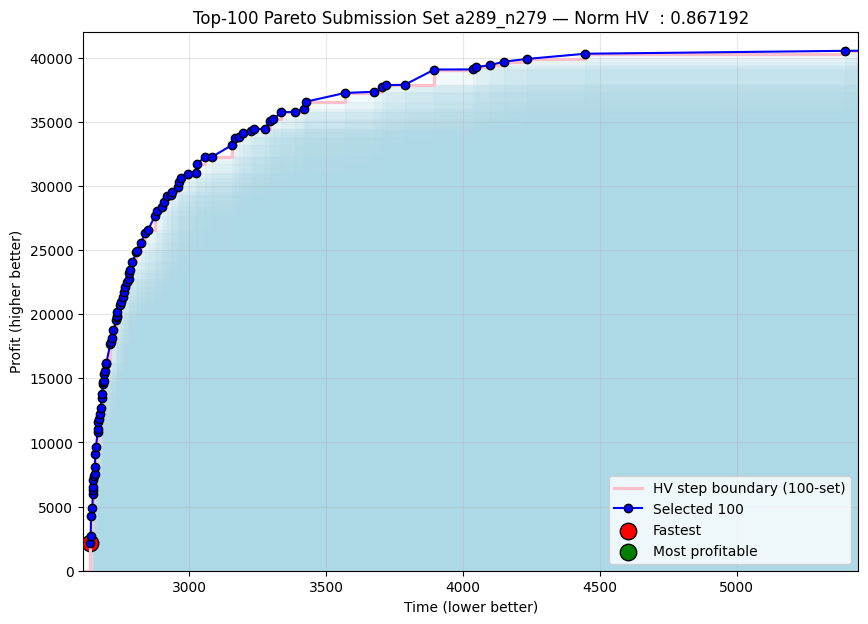

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

hv_raw_nd = compute_hypervolume(final_objs, IDEAL, NADIR)
hv_norm_nd = hv_raw_nd / (range_t * range_p)

print("\n=== SUMISSION HYPERVOLUME (ARCHIVE) ===")
print(f"Raw HV   : {hv_raw_nd:.6e}")
print(f"Norm HV  : {hv_norm_nd:.6f}")

# ================== USE SUBMISSION SET ==================
# not archive_objs — only final 20 exported points
pts = np.array([(t,p,g) for (t,p,w,g) in final_objs])
pts = pts[pts[:,0].argsort()]  # sort by time

times   = pts[:,0]
profits = pts[:,1]

T_min, T_max = IDEAL[0], NADIR[0]
P_min, P_max = 0, 42_036.0

plt.figure(figsize=(10,7))

# -------------------------------------------------
#  Dominated area shading for the displayed 20 only
# -------------------------------------------------
for i in range(len(times)):
    xs = [times[i], T_max, T_max, times[i]]
    ys = [P_min, P_min, profits[i], profits[i]]
    plt.fill(xs, ys, color="lightblue", alpha=0.15)

# -------------------------------------------------
# Hypervolume boundary (step front)
# -------------------------------------------------
hv_x = [T_min]
hv_y = [P_min]

for t,p in zip(times, profits):
    hv_x += [t, t]
    hv_y += [hv_y[-1], p]

hv_x.append(T_max)
hv_y.append(hv_y[-1])

plt.plot(hv_x, hv_y, color="pink", linewidth=2.3,
         label="HV step boundary (100-set)")

# -------------------------------------------------
# Pareto front scatter
# -------------------------------------------------
plt.plot(times, profits, "-o", color="blue", markersize=6,
         markeredgecolor="black", label="Selected 100")

# Best markers
best_t = np.argmin(times)
best_p = np.argmax(profits)

plt.scatter(times[best_t], profits[best_t], s=140,
            color="red", edgecolor="black", label="Fastest")
plt.scatter(times[best_p], profits[best_p], s=140,
            color="green", edgecolor="black", label="Most profitable")

plt.xlim(T_min, T_max)
plt.ylim(P_min, P_max)
plt.grid(alpha=0.3)
plt.xlabel("Time (lower better)")
plt.ylabel("Profit (higher better)")
plt.title(f"Top-100 Pareto Submission Set a289_n279 — Norm HV  : {hv_norm_nd:.6f}")
plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0.0))
plt.show()
